# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE # smote

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500,)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

8.0    5000
7.0    5000
6.0    5000
5.0    5000
3.0    5000
1.0    5000
0.0    5000
9.0    2500
4.0    2500
2.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

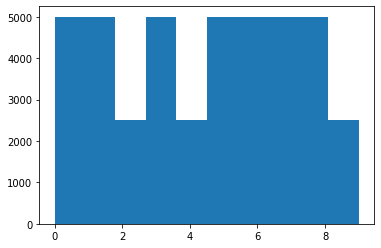

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

## AutoEncoder

#### Load AE models weight

In [10]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [11]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [12]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 8,8,128
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x)

    return Model(input_img, y)

#### Train SMOTE without data augumentation 

In [29]:
%%time

# train
saveDir = "../models/CNN/"
histories = []
nb_classes = 10
predicts = np.zeros((10000, 10))
cv_acc = 0
cv_f1 = 0

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model01 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]
    
    # over sampling smote
    sm = SMOTE(random_state=42)
    x_train_smote = x_train_.reshape(x_train_.shape[0],
                                    x_train_.shape[1]*x_train_.shape[2]*x_train_.shape[3])
    y_train_smote = y_train_.reshape(y_train_.shape[0])
    x_train_smote, y_train_smote = SMOTE().fit_resample(x_train_smote, y_train_smote)
    
    x_train_smote = x_train_smote.reshape((x_train_smote.shape[0], 
                                           x_train_removed.shape[1], 
                                           x_train_removed.shape[2], 
                                           x_train_removed.shape[3]))

    # one hot encoding
    y_train_onehot_smote = to_categorical(y_train_smote, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_023_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    model01_history = model01.fit(x_train_smote, y_train_onehot_smote,
                          batch_size=32,
                          epochs=400,
                          verbose=1,
                          validation_data=(x_valid_, y_valid_onehot),
                          callbacks=[es_cb, cp_cb],
                          shuffle=True)
    
    # inference
    model01.load_weights(chkpt)
    scores = model01.evaluate(x_valid_, y_valid_onehot)
    
    # CV value
    cv_acc += scores[1]*100
    y_valid_pred =  model01.predict(x_valid_)
    y_valid_pred = np.argmax(y_valid_pred, axis=1)
    cv_f1 += f1_score(y_valid_, y_valid_pred, average='macro')*100
    
    print(f'Score for fold {fold_no}: {model01.metrics_names[0]} of {scores[0]}; {model01.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model01.predict(x_test)
    predicts += predict
    
    histories.append(model01_history.history)
    fold_no += 1

Epoch 1/400
1039/1042 [============================>.] - ETA: 0s - loss: 1.3606 - accuracy: 0.5090
Epoch 00001: val_loss improved from inf to 1.53881, saving model to ../models/CNN\Model_023_1_Best.hdf5
1042/1042 [==============================] - 7s 7ms/step - loss: 1.3608 - accuracy: 0.5092 - val_loss: 1.5388 - val_accuracy: 0.4863
Epoch 2/400
1042/1042 [==============================] - ETA: 0s - loss: 0.9534 - accuracy: 0.6628
Epoch 00002: val_loss improved from 1.53881 to 0.94970, saving model to ../models/CNN\Model_023_1_Best.hdf5
1042/1042 [==============================] - 7s 6ms/step - loss: 0.9534 - accuracy: 0.6628 - val_loss: 0.9497 - val_accuracy: 0.6679
Epoch 3/400
1035/1042 [============================>.] - ETA: 0s - loss: 0.7598 - accuracy: 0.7342
Epoch 00003: val_loss improved from 0.94970 to 0.88596, saving model to ../models/CNN\Model_023_1_Best.hdf5
1042/1042 [==============================] - 6s 6ms/step - loss: 0.7597 - accuracy: 0.7342 - val_loss: 0.8860 - val_a

Epoch 00012: early stopping
443/443 [==============================] - 1s 2ms/step - loss: 0.8372 - accuracy: 0.7636
Score for fold 3: loss of 0.8372433185577393; accuracy of 76.35888457298279%
Wall time: 14min 45s


In [14]:
ensemble_histories = histories
ensemble_predicts = predicts
ensemble_predicts_ = ensemble_predicts / n_splits
y_pred = np.argmax(ensemble_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1000
           1       0.73      0.96      0.83      1000
           2       0.74      0.60      0.66      1000
           3       0.67      0.59      0.63      1000
           4       0.79      0.68      0.73      1000
           5       0.72      0.74      0.73      1000
           6       0.73      0.86      0.79      1000
           7       0.79      0.86      0.83      1000
           8       0.89      0.83      0.86      1000
           9       0.91      0.75      0.82      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



In [31]:
print(f'CV ACC is {cv_acc//n_splits},n_splits CV macro F1 is {cv_f1//n_splits}')

CV ACC is 73.0,n_splits CV macro F1 is 71.0


#### Train SMOTE with data augumentation

In [27]:
# train
saveDir = "../models/CNN/"
histories = []
nb_classes = 10
predicts = np.zeros((10000, 10))
cv_acc = 0
cv_f1 = 0

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model02 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # over sampling smote
    sm = SMOTE(random_state=42)
    x_train_smote = x_train_.reshape(x_train_.shape[0],
                                    x_train_.shape[1]*x_train_.shape[2]*x_train_.shape[3])
    y_train_smote = y_train_.reshape(y_train_.shape[0])
    x_train_smote, y_train_smote = SMOTE().fit_resample(x_train_smote, y_train_smote)
    
    x_train_smote = x_train_smote.reshape((x_train_smote.shape[0], 
                                           x_train_removed.shape[1], 
                                           x_train_removed.shape[2], 
                                           x_train_removed.shape[3]))

    # one hot encoding
    y_train_onehot_smote = to_categorical(y_train_smote, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_024_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    # create generator
    train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=10,
#         shear_range=0.2,
        horizontal_flip=True,
#         vertical_flip=True,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
        zoom_range=0.1
#         channel_shift_range=0.2
        )

    batch_size = 32
    train_datagenerator = train_datagen.flow(x_train_smote, y_train_onehot_smote, batch_size)
    valid_datagenerator = ImageDataGenerator().flow(x_valid_, y_valid_onehot, batch_size)

    model02_history = model02.fit_generator(train_datagenerator,
                                  steps_per_epoch=int(len(x_train_smote)//batch_size),
                                  epochs=400,
                                  validation_data=valid_datagenerator,
                                  validation_steps=int(len(x_valid_)//batch_size),
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[es_cb, cp_cb])

    # inference
    model02.load_weights(chkpt)
    scores = model02.evaluate(x_valid_, y_valid_onehot)
    
    # CV value
    cv_acc += scores[1]*100
    y_valid_pred =  model02.predict(x_valid_)
    y_valid_pred = np.argmax(y_valid_pred, axis=1)
    cv_f1 += f1_score(y_valid_, y_valid_pred, average='macro')*100
    
    print(f'Score for fold {fold_no}: {model02.metrics_names[0]} of {scores[0]}; {model02.metrics_names[1]} of {scores[1]*100}%')
    
    # oof prediction
    predict = model02.predict(x_test)
    predicts += predict
    
    histories.append(model02_history.history)
    fold_no += 1

Epoch 1/400
1038/1041 [============================>.] - ETA: 0s - loss: 1.4013 - accuracy: 0.4990
Epoch 00001: val_loss improved from inf to 1.27974, saving model to ../models/CNN\Model_024_1_Best.hdf5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.4009 - accuracy: 0.4990 - val_loss: 1.2797 - val_accuracy: 0.5602
Epoch 2/400
1035/1041 [============================>.] - ETA: 0s - loss: 1.0405 - accuracy: 0.6303
Epoch 00002: val_loss improved from 1.27974 to 1.02669, saving model to ../models/CNN\Model_024_1_Best.hdf5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.0393 - accuracy: 0.6306 - val_loss: 1.0267 - val_accuracy: 0.6454
Epoch 3/400
1037/1041 [============================>.] - ETA: 0s - loss: 0.8817 - accuracy: 0.6888
Epoch 00003: val_loss improved from 1.02669 to 1.00696, saving model to ../models/CNN\Model_024_1_Best.hdf5
1041/1041 [==============================] - 10s 10ms/step - loss: 0.8820 - accuracy: 0.6886 - val_loss: 1.0070 -

Epoch 3/400
1036/1041 [============================>.] - ETA: 0s - loss: 0.8816 - accuracy: 0.6888
Epoch 00003: val_loss improved from 1.11526 to 1.02191, saving model to ../models/CNN\Model_024_3_Best.hdf5
1041/1041 [==============================] - 9s 9ms/step - loss: 0.8818 - accuracy: 0.6885 - val_loss: 1.0219 - val_accuracy: 0.6588
Epoch 4/400
1041/1041 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.7257
Epoch 00004: val_loss improved from 1.02191 to 0.97255, saving model to ../models/CNN\Model_024_3_Best.hdf5
1041/1041 [==============================] - 9s 9ms/step - loss: 0.7759 - accuracy: 0.7257 - val_loss: 0.9726 - val_accuracy: 0.6840
Epoch 5/400
1039/1041 [============================>.] - ETA: 0s - loss: 0.6953 - accuracy: 0.7570
Epoch 00005: val_loss improved from 0.97255 to 0.88231, saving model to ../models/CNN\Model_024_3_Best.hdf5
1041/1041 [==============================] - 9s 9ms/step - loss: 0.6957 - accuracy: 0.7569 - val_loss: 0.8823 - v

In [17]:
ensemble_dataaug_histories = histories
ensemble_dataaug_predicts = predicts
ensemble_dataaug_predicts_ = ensemble_dataaug_predicts / n_splits
y_pred = np.argmax(ensemble_dataaug_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.90      0.93      0.91      1000
           2       0.82      0.65      0.72      1000
           3       0.64      0.73      0.68      1000
           4       0.91      0.62      0.73      1000
           5       0.78      0.76      0.77      1000
           6       0.71      0.92      0.80      1000
           7       0.80      0.90      0.85      1000
           8       0.92      0.90      0.91      1000
           9       0.90      0.86      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



In [28]:
print(f'CV ACC is {cv_acc//n_splits}, CV macro F1 is {cv_f1//n_splits}')

CV ACC is 76.0, CV macro F1 is 75.0
